<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula04a_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

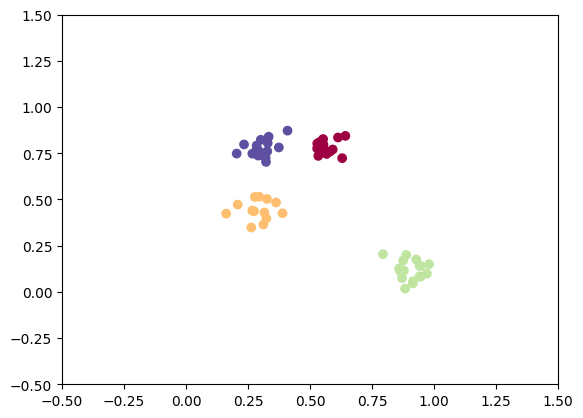

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def plot_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    return plt

def plot_hiperplano(vector, intercept):
  xs = np.array([0, 1])
  ys = -(vector[0] * xs + intercept) / vector[1]
  plt.plot(xs, ys, '-')

def make_multiclass_dataset(n=20, n_classes=4):
  X, y = make_blobs(n_samples=n * n_classes,
                     centers=n_classes,
                     n_features=2,
                     center_box=(0,1),
                     cluster_std=0.05)
  return X, y

X, y = make_multiclass_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
_ = plot_dataset(X_train, y_train)

0.203125


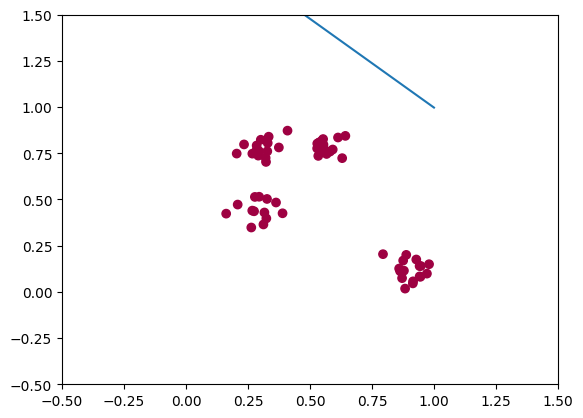

In [74]:
from abc import ABC, abstractstaticmethod, abstractmethod
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class Cost(ABC):
  @abstractstaticmethod
  def get_cost(y, y_pred):
    pass
  @abstractstaticmethod
  def get_grad(y, y_pred):
    pass

class WidrowHoff(Cost):
  @staticmethod
  def get_cost(y, y_pred):
    return 0.5 * np.sum((y - y_pred) ** 2)
  @staticmethod
  def get_grad(y, y_pred, X):
    return X.T @ (y_pred - y)


class TrainingAlgorithm(ABC):
  @abstractmethod
  def get_w(X, y):
    pass

class GradientDescent(TrainingAlgorithm):
  def __init__(self, learning_rate=0.01, max_iter=1000,
               regularization=0, cost=WidrowHoff()):
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.cost = cost
    self.regularization = regularization
  def get_w(self, X, y):
    w = np.zeros(X.shape[1])
    for i in range(self.max_iter):
      y_pred = X @ w
      grad = self.cost.get_grad(y, y_pred, X)
      w *= (1 - self.learning_rate * self.regularization)
      w -= self.learning_rate * grad
      if self.cost.get_cost(y, y_pred) < 1e-6:
        break
    return w

def sign(a):
  return (a >= 0).astype(int) * 2 - 1


def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  return np.concatenate((bias, X), axis=1)


class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=GradientDescent()):
    self.training_algorithm = training_algorithm

  def fit(self, X, y):
    X = include_bias(X)
    self.w = self.training_algorithm.get_w(X, y)
    return self

  def predict(self, X):
    X = include_bias(X)
    return sign(X @ self.w)

model = NeuralNetwork()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(accuracy_score(y_train, y_pred))
plot_dataset(X_train, y_pred)
plot_hiperplano(model.w[1:], model.w[0])

In [75]:
print(y_train)
print(y_pred)

[0 3 3 2 1 0 2 0 2 0 2 0 3 0 1 2 1 3 2 1 3 1 1 3 3 2 1 0 1 2 3 0 3 0 0 1 1
 1 2 1 2 3 0 2 3 2 1 0 0 0 2 2 3 3 2 0 0 0 3 3 2 2 2 3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


0.953125


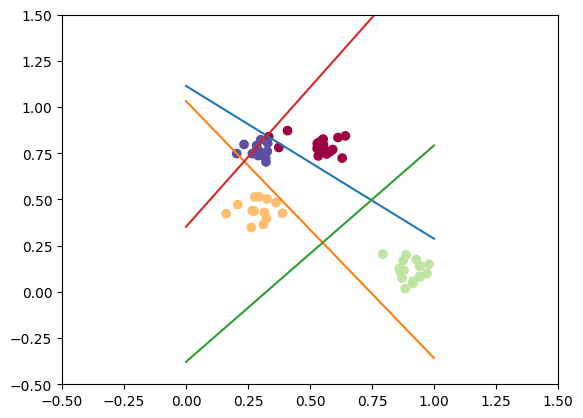

In [76]:
from sklearn.preprocessing import LabelBinarizer

class GradientDescent(TrainingAlgorithm):
  def __init__(self, learning_rate=0.01, max_iter=1000,
               regularization=0, cost=WidrowHoff()):
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.cost = cost
    self.regularization = regularization
  def get_w(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for i in range(self.max_iter):
      y_pred = X @ w
      grad = self.cost.get_grad(y, y_pred, X)
      w *= (1 - self.learning_rate * self.regularization)
      w -= self.learning_rate * grad
      if self.cost.get_cost(y, y_pred) < 1e-6:
        break
    return w

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=GradientDescent()):
    self.training_algorithm = training_algorithm

  def fit(self, X, y):
    self.label_binarizer = LabelBinarizer()
    # print(y.shape)
    y = self.label_binarizer.fit_transform(y)
    y = np.where(y == 0, -1, 1)
    # print(y.shape)
    X = include_bias(X)
    self.w = self.training_algorithm.get_w(X, y)
    # print(self.w.shape)
    return self

  def predict(self, X):
    X = include_bias(X)
    y_pred = X @ self.w
    if self.w.shape[1] == 1:
      return sign(y_pred)
    return self.label_binarizer.inverse_transform(y_pred)

model = NeuralNetwork()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(accuracy_score(y_train, y_pred))
plot_dataset(X_train, y_pred)
for i in range(model.w.shape[1]):
  plot_hiperplano(model.w[1:, i], model.w[0, i])

In [77]:
model.w

array([[-3.64705835,  2.52939806, -0.60756612, -0.27477438],
       [ 2.70575987, -3.40540684,  1.87811569, -1.17846793],
       [ 3.27209497, -2.44896149, -1.60407667,  0.78094385]])

0.9375


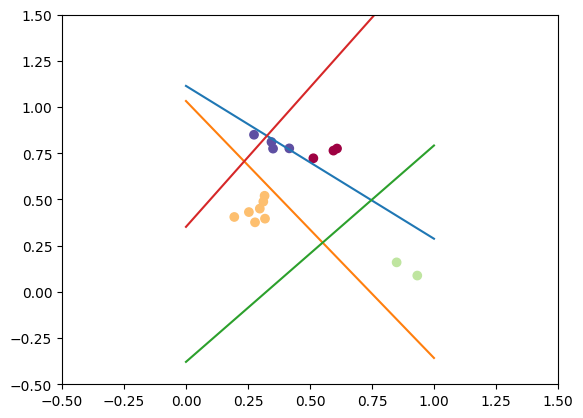

In [79]:
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plot_dataset(X_test, y_test)
for i in range(model.w.shape[1]):
  plot_hiperplano(model.w[1:, i], model.w[0, i])